C:\Users\kjp94\anaconda3\Lib\site-packages\yfinance\base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()
[*********************100%%**********************]  1 of 1 completed
C:\Users\kjp94\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 72s 586ms/step - loss: 0.0237
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 78s 551ms/step - loss: 0.0028
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 45s 596ms/step - loss: 0.0025
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 77s 518ms/step - loss: 0.0031
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 42s 530ms/step - loss: 0.0020
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 41s 569ms/step - loss: 0.0023
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 42s 574ms/step - loss: 0.0020
Epoch 8/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 78s 522ms/step - loss: 0.0021
Epoch 9/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 40s 511ms/step - loss: 0.0018
Epoch 10/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 41s 510ms/step - loss: 0.0019
Epoch 11/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 42s 519ms/step - loss: 0.0015
Epoch 12/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 41s 515ms/step - loss: 0.0019
Epoch 13/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 43s 532ms/step - loss: 0.0020
Epoch 14/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 42s 549ms/step - loss: 0.0015
Epoch 15/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 42s 

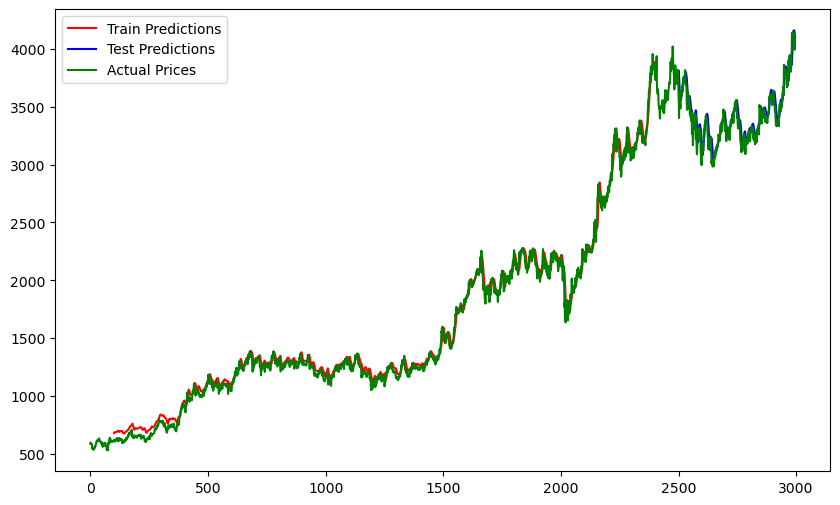

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error

# Downloading data
start = '2012-01-01'
end = '2024-02-26'
stock = 'TCS.NS'

data = yf.download(stock, start, end)
data.reset_index(inplace=True)

# Moving averages
ma_100_days = data.Close.rolling(100).mean()
ma_200_days = data.Close.rolling(200).mean()

# Data splitting
data.dropna(inplace=True)
train_size = int(len(data) * 0.80)
data_train = data.Close.values[:train_size].reshape(-1, 1)
data_test = data.Close.values[train_size:].reshape(-1, 1)

# Scaling data
scaler = MinMaxScaler(feature_range=(0, 1))
data_train_scale = scaler.fit_transform(data_train)
data_test_scale = scaler.transform(data_test)

# Preparing training and testing data
def prepare_data(data, window_size):
    x, y = [], []
    for i in range(window_size, len(data)):
        x.append(data[i - window_size:i, 0])
        y.append(data[i, 0])
    return np.array(x), np.array(y)

window_size = 100
x_train, y_train = prepare_data(data_train_scale, window_size)
x_test, y_test = prepare_data(data_test_scale, window_size)

# Reshaping data for LSTM
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Building the LSTM model
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(units=60, return_sequences=True),
    Dropout(0.3),
    LSTM(units=80, return_sequences=True),
    Dropout(0.4),
    LSTM(units=120),
    Dropout(0.5),
    Dense(units=1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Training the model
model.fit(x_train, y_train, epochs=50, batch_size=32, verbose=1)

# Making predictions
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

# Inverse scaling
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

# Model evaluation
train_score = mean_squared_error(y_train[0], train_predict[:, 0])
test_score = mean_squared_error(y_test[0], test_predict[:, 0])

print('Train Score: {:.2f} MSE'.format(train_score))
print('Test Score: {:.2f} MSE'.format(test_score))

# Plotting results
plt.figure(figsize=(10, 6))
plt.plot(data.index[window_size:train_size], train_predict, 'r', label='Train Predictions')
plt.plot(data.index[train_size+window_size:], test_predict, 'b', label='Test Predictions')
plt.plot(data.index, data.Close, 'g', label='Actual Prices')
plt.legend()
plt.show()


In [2]:
model.save('Stock Predictions Model 2025.keras')